In [ ]:
!apt-get install -y p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# Change this qpath to your file location
archive_path = "/content/face_mask_.7z"

# Extract to ./extracted directory
!7z x "{archive_path}" -o./extracted



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 160887189 bytes (154 MiB)

Extracting archive: /content/face_mask_.7z
--
Path = /content/face_mask_.7z
Type = 7z
Physical Size = 160887189
Headers Size = 48653
Method = LZMA:23
Solid = +
Blocks = 1

  0%      2%    
Would you like to replace the existing file:
  Path:     ./extracted/dataset/without_mask/0.jpg
  Size:     21764 bytes (22 KiB)
  Modified: 2022-04-16 10:38:33
with the file from archive:
  Path:     dataset/without_mask/0.jpg
  Size:     21764 bytes (22 KiB)
  Modified: 2022-04-16 10:38:33
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

In [ ]:
import os
import time
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers

In [ ]:
import os
import time
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers

def create_densenet_model(input_shape=(128, 128, 3)):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)


    # Binary classification: 1 output neuron with sigmoid activation
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base DenseNet layers (optional; you can also fine-tune)

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
# Paths
with_mask_dir = "/content/augmented_data/with_mask"
without_mask_dir = "/content/augmented_data/without_mask"

# Lists
train_images = []
train_labels = []

# Size
newsize = (128, 128)

# Load "with_mask" images
for filename in os.listdir(with_mask_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img = Image.open(os.path.join(with_mask_dir, filename)).convert("RGB")
        img = img.resize(newsize)
        img_arr = np.array(img)
        train_images.append(img_arr)
        train_labels.append(0)

# Load "without_mask" images
for filename in os.listdir(without_mask_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img = Image.open(os.path.join(without_mask_dir, filename)).convert("RGB")
        img = img.resize(newsize)
        img_arr = np.array(img)
        train_images.append(img_arr)
        train_labels.append(1)


In [ ]:
# Convert to numpy array
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Remove images with wrong shape
valid_idx = [i for i, img in enumerate(train_images) if img.shape == (128,128,3)]
train_images = train_images[valid_idx]
train_labels = train_labels[valid_idx]

print("Total images:", train_images.shape[0])


Total images: 5588


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_labels, test_size=0.3, random_state=42
)

In [ ]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0


In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set your original data (X_train and y_train must be defined)
# X_train: shape (N, 224, 224, 3)
# y_train: shape (N,) or (N, 1) with labels 0 or 1

# Directory to save images
save_dir = "/content/augmented_data"
with_mask_dir = os.path.join(save_dir, "with_mask")
without_mask_dir = os.path.join(save_dir, "without_mask")
os.makedirs(with_mask_dir, exist_ok=True)
os.makedirs(without_mask_dir, exist_ok=True)

# Image augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Save original + augmented images
print(f"Saving original and augmented images to '{save_dir}'...")

saved_counts = {0: 0, 1: 0}

for i in range(len(X_train)):
    img = X_train[i]
    label = int(y_train[i])  # Make sure it's scalar 0 or 1

    # Denormalize if needed (e.g., if images are 0-1 floats)
    if img.max() <= 1.0:
        original_img = (img * 255).astype(np.uint8)
    else:
        original_img = img.astype(np.uint8)

    # Save original image
    label_dir = with_mask_dir if label == 0 else without_mask_dir
    orig_filename = f"orig_{saved_counts[label]+1}.png"
    cv2.imwrite(os.path.join(label_dir, orig_filename), cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR))

    # Expand dimensions for augmentation (batch size = 1)
    img_expanded = np.expand_dims(img, axis=0)
    aug_iter = datagen.flow(img_expanded, batch_size=1)

    # Get one augmented image
    aug_img = next(aug_iter)[0]
    aug_img = (aug_img * 255).astype(np.uint8)

    # Save augmented image
    aug_filename = f"aug_{saved_counts[label]+1}.png"
    cv2.imwrite(os.path.join(label_dir, aug_filename), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

    saved_counts[label] += 1

print("✅ All original and augmented images saved successfully.")


Saving original and augmented images to '/content/augmented_data'...
✅ All original and augmented images saved successfully.



--- Training Fold 1 ---
Epoch 1/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 48s 549ms/step - accuracy: 0.8878 - loss: 0.3074 - val_accuracy: 0.9745 - val_loss: 0.0701
Epoch 2/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9643 - loss: 0.0908 - val_accuracy: 0.9834 - val_loss: 0.0526
Epoch 3/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9727 - loss: 0.0729 - val_accuracy: 0.9872 - val_loss: 0.0546
Epoch 4/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9743 - loss: 0.0672 - val_accuracy: 0.9860 - val_loss: 0.0417
Epoch 5/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9801 - loss: 0.0616 - val_accuracy: 0.9898 - val_loss: 0.0406
Epoch 6/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9786 - loss: 0.0565 - val_accuracy: 0.9898 - val_loss: 0.0435
Epoch 7/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9752 - loss: 0.0526 - val_accuracy: 0.9885 - val_loss: 0.0432
Epoch 8/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9762 - loss: 0.0600

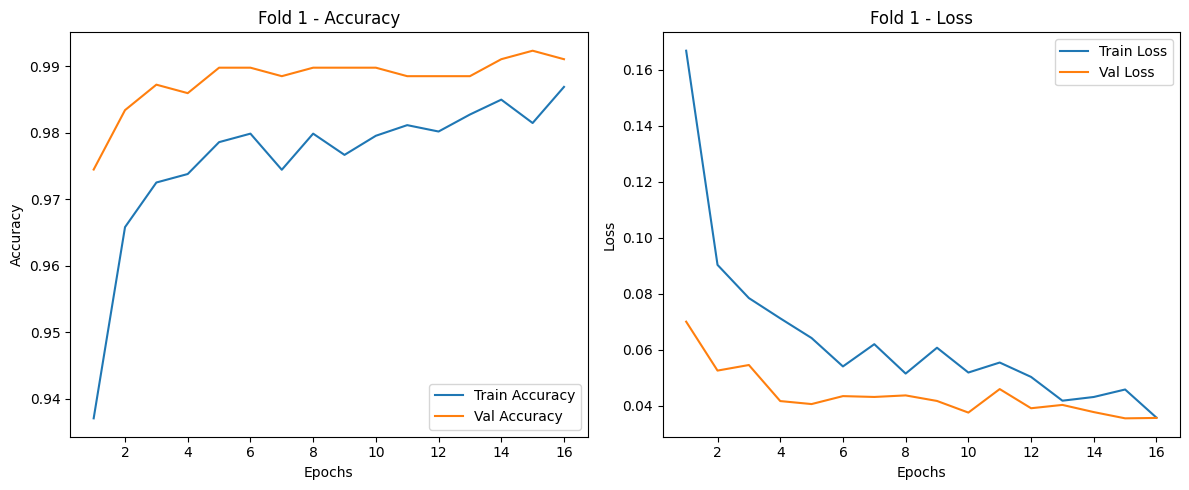


--- Training Fold 2 ---
Epoch 1/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 50s 551ms/step - accuracy: 0.8861 - loss: 0.2986 - val_accuracy: 0.9770 - val_loss: 0.0602
Epoch 2/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9597 - loss: 0.1210 - val_accuracy: 0.9693 - val_loss: 0.0688
Epoch 3/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9648 - loss: 0.0989 - val_accuracy: 0.9770 - val_loss: 0.0550
Epoch 4/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9661 - loss: 0.0778 - val_accuracy: 0.9872 - val_loss: 0.0394
Epoch 5/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9777 - loss: 0.0519 - val_accuracy: 0.9847 - val_loss: 0.0360
Epoch 6/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9808 - loss: 0.0509 - val_accuracy: 0.9859 - val_loss: 0.0374
Epoch 7/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9809 - loss: 0.0543 - val_accuracy: 0.9821 - val_loss: 0.0456
Epoch 8/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9852 - loss: 0.0429

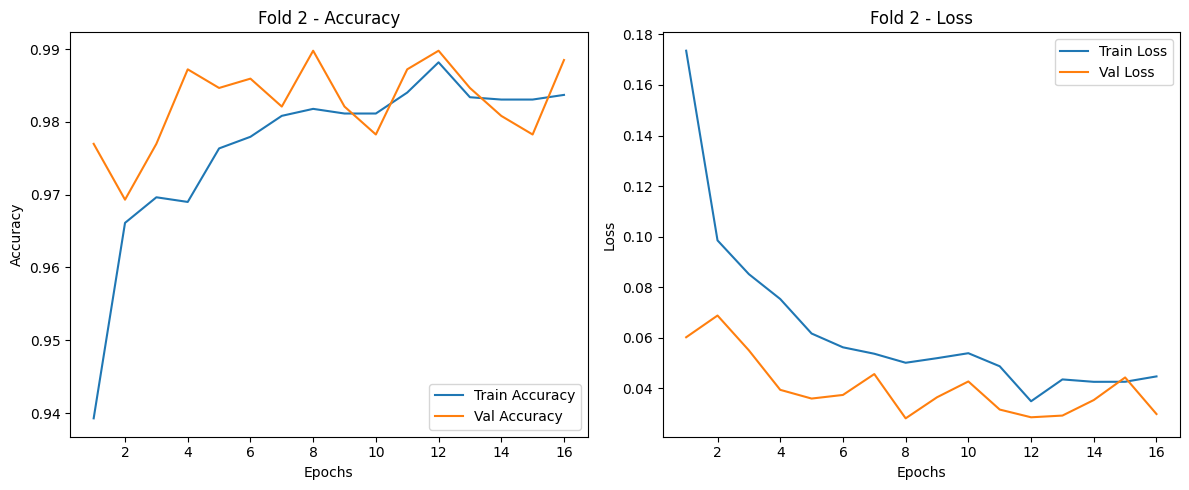


--- Training Fold 3 ---
Epoch 1/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 48s 564ms/step - accuracy: 0.8149 - loss: 0.5114 - val_accuracy: 0.9808 - val_loss: 0.0625
Epoch 2/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9688 - loss: 0.0915 - val_accuracy: 0.9770 - val_loss: 0.0590
Epoch 3/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9690 - loss: 0.0701 - val_accuracy: 0.9834 - val_loss: 0.0509
Epoch 4/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9746 - loss: 0.0791 - val_accuracy: 0.9859 - val_loss: 0.0425
Epoch 5/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9790 - loss: 0.0505 - val_accuracy: 0.9859 - val_loss: 0.0419
Epoch 6/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9788 - loss: 0.0526 - val_accuracy: 0.9821 - val_loss: 0.0434
Epoch 7/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9803 - loss: 0.0583 - val_accuracy: 0.9834 - val_loss: 0.0455
Epoch 8/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9828 - loss: 0.0472

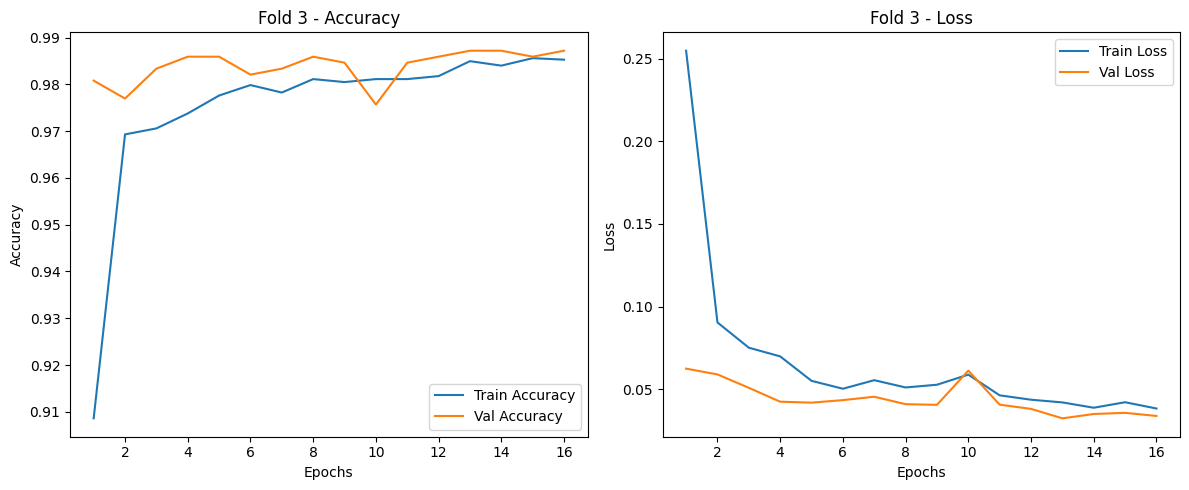


--- Training Fold 4 ---
Epoch 1/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 771ms/step - accuracy: 0.8794 - loss: 0.2935 - val_accuracy: 0.9872 - val_loss: 0.0367
Epoch 2/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9738 - loss: 0.0768 - val_accuracy: 0.9885 - val_loss: 0.0310
Epoch 3/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9734 - loss: 0.0697 - val_accuracy: 0.9872 - val_loss: 0.0279
Epoch 4/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9667 - loss: 0.0821 - val_accuracy: 0.9872 - val_loss: 0.0325
Epoch 5/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9739 - loss: 0.0596 - val_accuracy: 0.9898 - val_loss: 0.0279
Epoch 6/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9801 - loss: 0.0667 - val_accuracy: 0.9885 - val_loss: 0.0295
Epoch 7/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9746 - loss: 0.0625 - val_accuracy: 0.9898 - val_loss: 0.0259
Epoch 8/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9792 - loss: 0.057

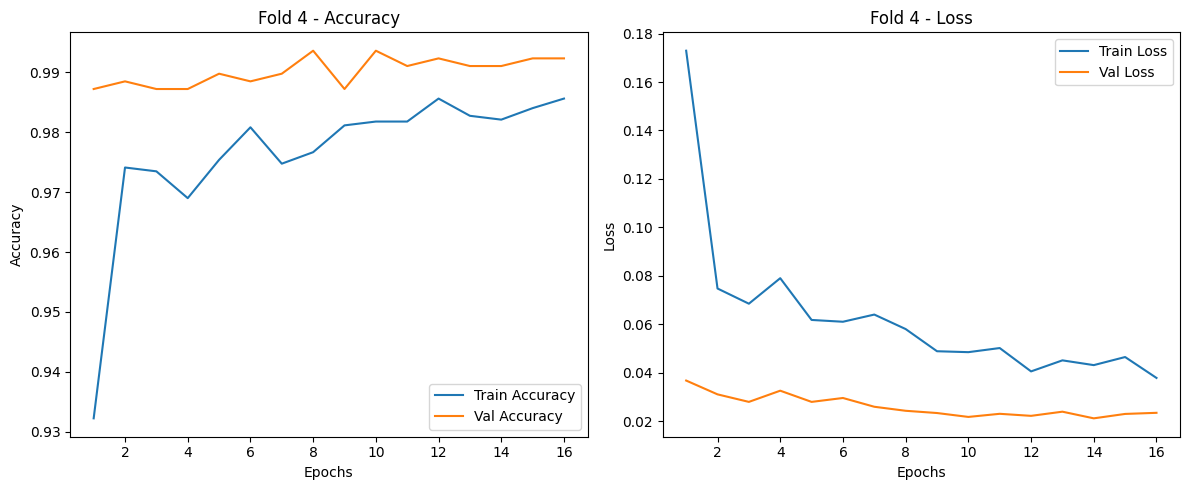


--- Training Fold 5 ---
Epoch 1/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 57s 745ms/step - accuracy: 0.8615 - loss: 0.3219 - val_accuracy: 0.9834 - val_loss: 0.0512
Epoch 2/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.9671 - loss: 0.0804 - val_accuracy: 0.9859 - val_loss: 0.0362
Epoch 3/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9627 - loss: 0.1010 - val_accuracy: 0.9898 - val_loss: 0.0316
Epoch 4/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9726 - loss: 0.0625 - val_accuracy: 0.9898 - val_loss: 0.0297
Epoch 5/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9720 - loss: 0.0657 - val_accuracy: 0.9885 - val_loss: 0.0272
Epoch 6/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9814 - loss: 0.0487 - val_accuracy: 0.9872 - val_loss: 0.0260
Epoch 7/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9714 - loss: 0.0666 - val_accuracy: 0.9898 - val_loss: 0.0239
Epoch 8/16
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9787 - loss: 0.057

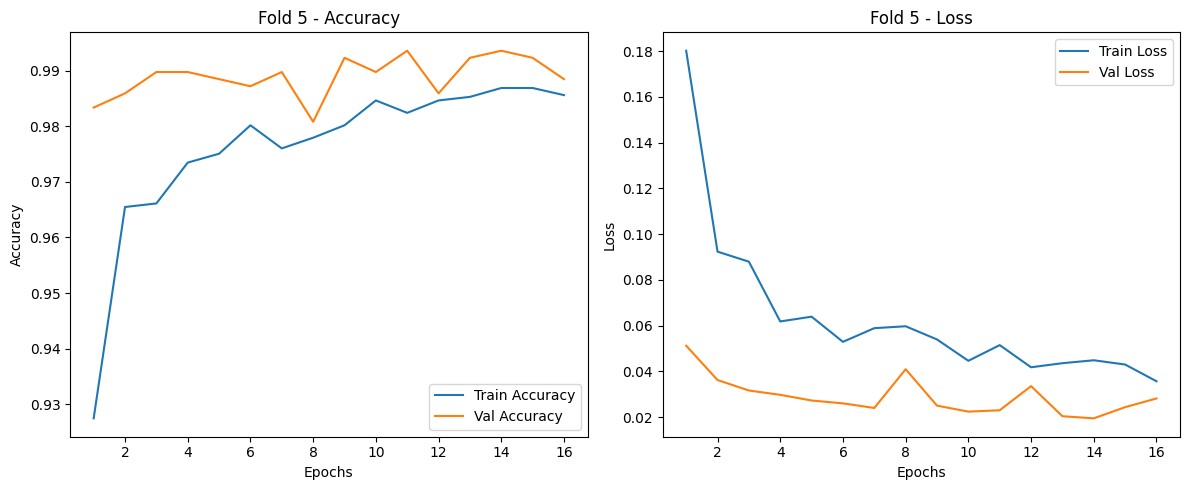

In [ ]:
# ------------ PLOTTING FUNCTION ------------
def plot_history(history, fold_num):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'Fold {fold_num} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'Fold {fold_num} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
histories = []

fold = 1
for train_idx, val_idx in kf.split(X_train):
    print(f"\n--- Training Fold {fold} ---")

    # Split data
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Create and train model
    model = create_densenet_model()
    history = model.fit(
        X_tr, y_tr,
        epochs=16,
        batch_size=64,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Save history & plot
    histories.append(history)
    plot_history(history, fold)

    fold += 1


In [ ]:
import os
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Paths
base_dir = "/content/augmented_data"
img_size = (128, 128)
batch_size = 128
epochs = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Build model
def create_densenet_model(input_shape=(128, 128, 3)):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_densenet_model(input_shape=(128, 128, 3))

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

# Save model
model.save("densenet_mask_classifier.h5")
print("✅ Model trained and saved.")


Found 4471 images belonging to 2 classes.
Found 1117 images belonging to 2 classes.
Epoch 1/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8481 - loss: 0.5138 - val_accuracy: 0.9758 - val_loss: 0.2090 - learning_rate: 0.0010
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9688 - loss: 0.2144 - val_accuracy: 0.9794 - val_loss: 0.1647 - learning_rate: 0.0010
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.9754 - loss: 0.1617 - val_accuracy: 0.9821 - val_loss: 0.1467 - learning_rate: 0.0010
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9747 - loss: 0.1676 - val_accuracy: 0.9848 - val_loss: 0.1358 - learning_rate: 0.0010
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.9730 - loss: 0.1468 - val_accuracy: 0.9893 - val_loss: 0.1226 - learning_rate: 0.0010
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9741 - loss: 0.1390 - val_accuracy: 0.9875 - val_loss: 0.1168 - learning_rate: 0.0010
Epoch 

✅ Model trained and saved.


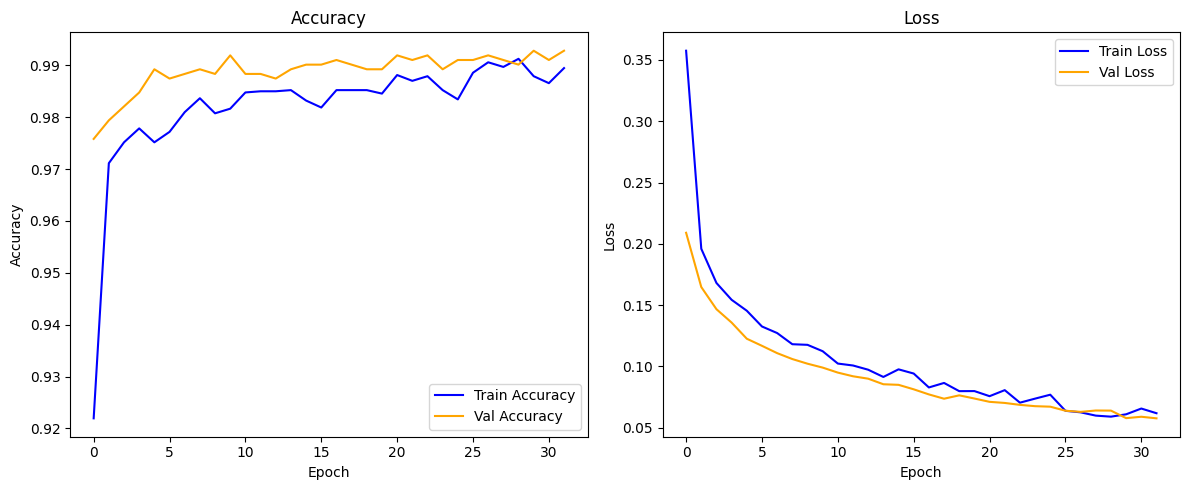

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Total samples: 5588

🔁 Fold 1 / 5
Found 4470 validated image filenames belonging to 2 classes.
Found 1118 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7795 - loss: 0.7881 - val_accuracy: 0.9785 - val_loss: 0.2122 - learning_rate: 0.0010
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9654 - loss: 0.2408 - val_accuracy: 0.9803 - val_loss: 0.1649 - learning_rate: 0.0010
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.9732 - loss: 0.1857 - val_accuracy: 0.9839 - val_loss: 0.1500 - learning_rate: 0.0010
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.9806 - loss: 0.1602 - val_accuracy: 0.9848 - val_loss: 0.1389 - learning_rate: 0.0010
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.9730 - loss: 0.1631 - val_accuracy: 0.9866 - val_loss: 0.1302 - learning_rate: 0.0010
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.9768 - loss: 0.1544 - val_accuracy: 0.9848 - val_loss: 0.1223 - learning_rate: 0.0010
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.9799 - loss: 0.1376 - va

✅ Saved model for fold 1


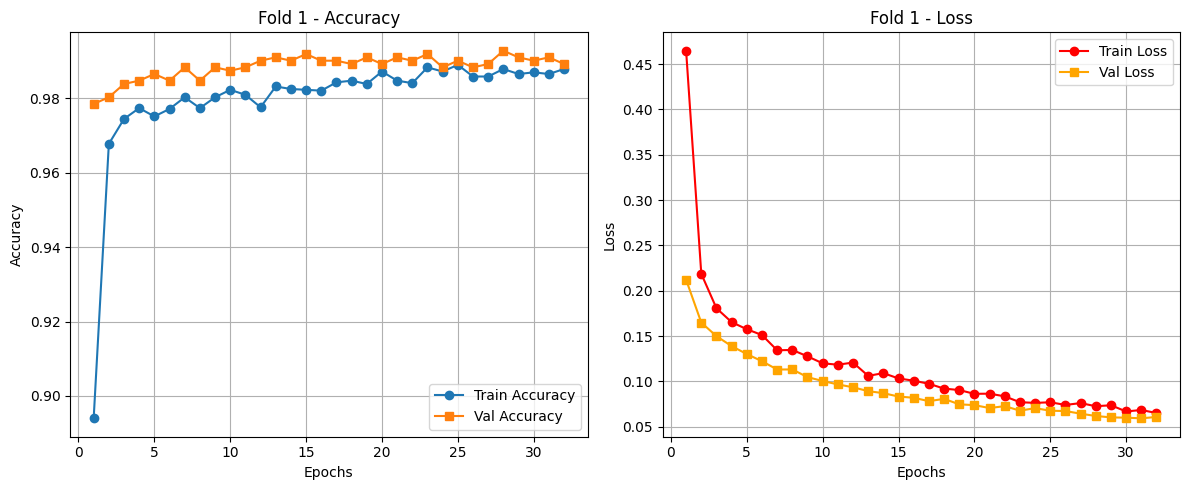


🔁 Fold 2 / 5
Found 4470 validated image filenames belonging to 2 classes.
Found 1118 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 934ms/step - accuracy: 0.8118 - loss: 0.6341 - val_accuracy: 0.9848 - val_loss: 0.1896 - learning_rate: 0.0010
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9654 - loss: 0.2202 - val_accuracy: 0.9893 - val_loss: 0.1509 - learning_rate: 0.0010
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.9670 - loss: 0.1931 - val_accuracy: 0.9884 - val_loss: 0.1344 - learning_rate: 0.0010
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.9789 - loss: 0.1587 - val_accuracy: 0.9866 - val_loss: 0.1238 - learning_rate: 0.0010
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.9796 - loss: 0.1494 - val_accuracy: 0.9902 - val_loss: 0.1164 - learning_rate: 0.0010
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.9794 - loss: 0.1413 - val_accuracy: 0.9902 - val_loss: 0.1087 - learning_rate: 0.0010
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9753 - loss: 0.1422 -

✅ Saved model for fold 2


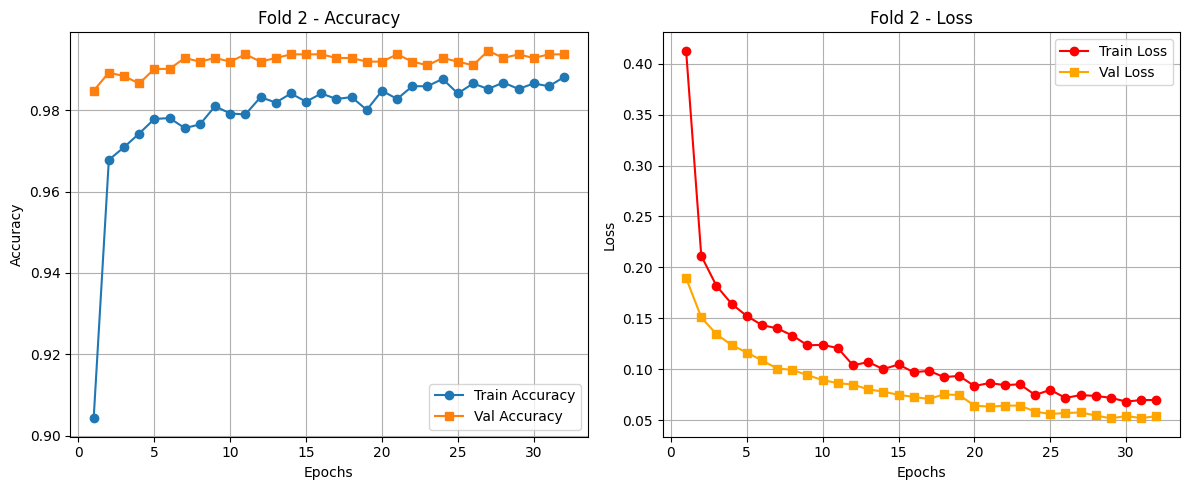


🔁 Fold 3 / 5
Found 4470 validated image filenames belonging to 2 classes.
Found 1118 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 919ms/step - accuracy: 0.8475 - loss: 0.5427 - val_accuracy: 0.9848 - val_loss: 0.1826 - learning_rate: 0.0010
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.9657 - loss: 0.2157 - val_accuracy: 0.9902 - val_loss: 0.1428 - learning_rate: 0.0010
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9709 - loss: 0.1848 - val_accuracy: 0.9875 - val_loss: 0.1307 - learning_rate: 0.0010
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.9805 - loss: 0.1557 - val_accuracy: 0.9902 - val_loss: 0.1233 - learning_rate: 0.0010
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.9723 - loss: 0.1554 - val_accuracy: 0.9893 - val_loss: 0.1165 - learning_rate: 0.0010
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.9774 - loss: 0.1464 - val_accuracy: 0.9919 - val_loss: 0.1061 - learning_rate: 0.0010
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.9775 - loss: 0.1404 -

✅ Saved model for fold 3


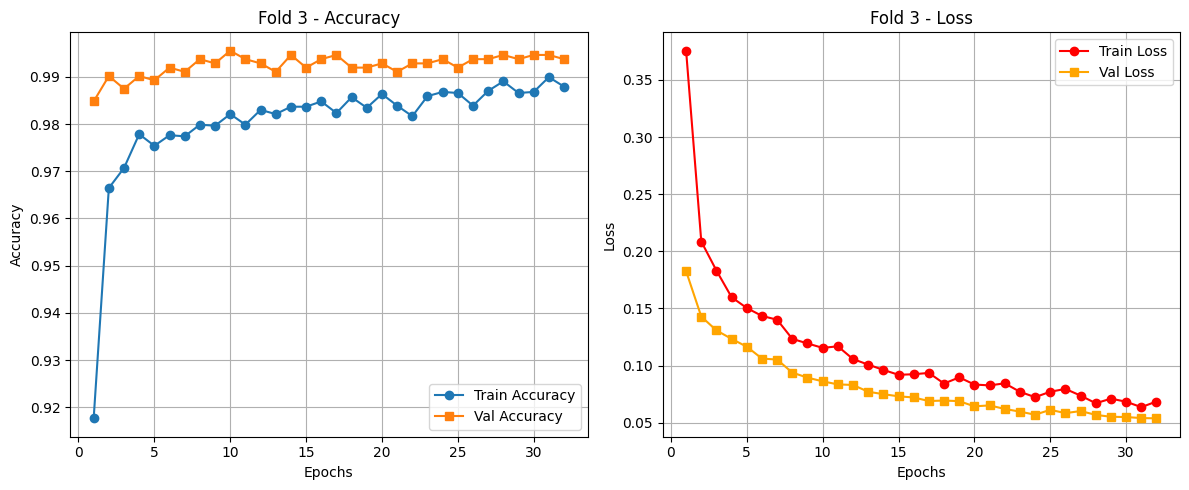


🔁 Fold 4 / 5
Found 4471 validated image filenames belonging to 2 classes.
Found 1117 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8289 - loss: 0.6027 - val_accuracy: 0.9821 - val_loss: 0.1999 - learning_rate: 0.0010
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.9631 - loss: 0.2264 - val_accuracy: 0.9848 - val_loss: 0.1554 - learning_rate: 0.0010
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.9699 - loss: 0.1865 - val_accuracy: 0.9848 - val_loss: 0.1373 - learning_rate: 0.0010
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9723 - loss: 0.1727 - val_accuracy: 0.9821 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.9771 - loss: 0.1483 - val_accuracy: 0.9848 - val_loss: 0.1263 - learning_rate: 0.0010
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.9797 - loss: 0.1387 - val_accuracy: 0.9848 - val_loss: 0.1188 - learning_rate: 0.0010
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.9772 - loss: 0.1393 - va

✅ Saved model for fold 4


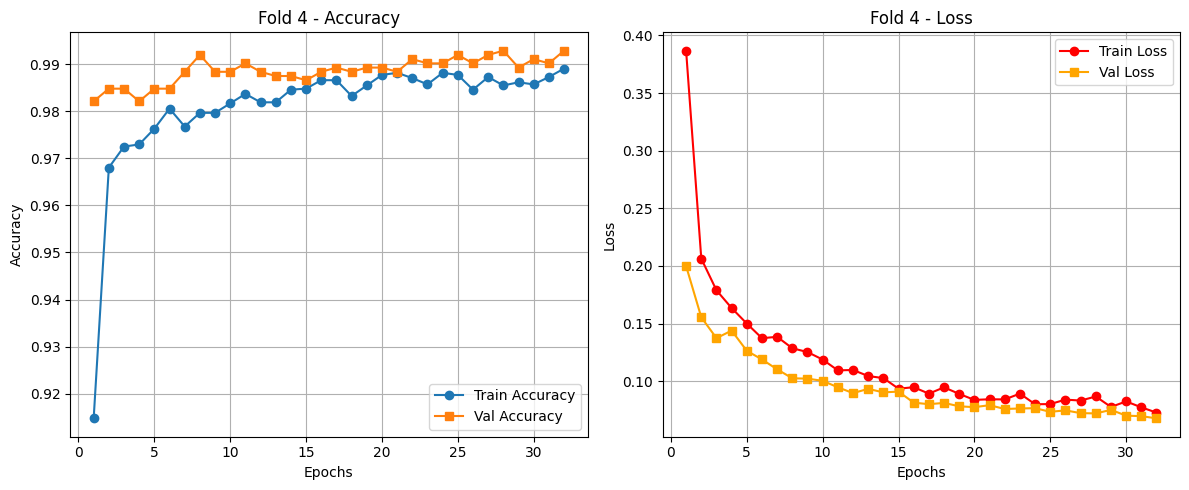


🔁 Fold 5 / 5
Found 4471 validated image filenames belonging to 2 classes.
Found 1117 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 942ms/step - accuracy: 0.8711 - loss: 0.5499 - val_accuracy: 0.9785 - val_loss: 0.1926 - learning_rate: 0.0010
Epoch 2/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.9681 - loss: 0.2144 - val_accuracy: 0.9848 - val_loss: 0.1518 - learning_rate: 0.0010
Epoch 3/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9742 - loss: 0.1832 - val_accuracy: 0.9884 - val_loss: 0.1344 - learning_rate: 0.0010
Epoch 4/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.9748 - loss: 0.1592 - val_accuracy: 0.9866 - val_loss: 0.1257 - learning_rate: 0.0010
Epoch 5/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.9764 - loss: 0.1526 - val_accuracy: 0.9893 - val_loss: 0.1165 - learning_rate: 0.0010
Epoch 6/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.9787 - loss: 0.1363 - val_accuracy: 0.9902 - val_loss: 0.1097 - learning_rate: 0.0010
Epoch 7/32
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.9770 - loss: 0.1437 -

✅ Saved model for fold 5


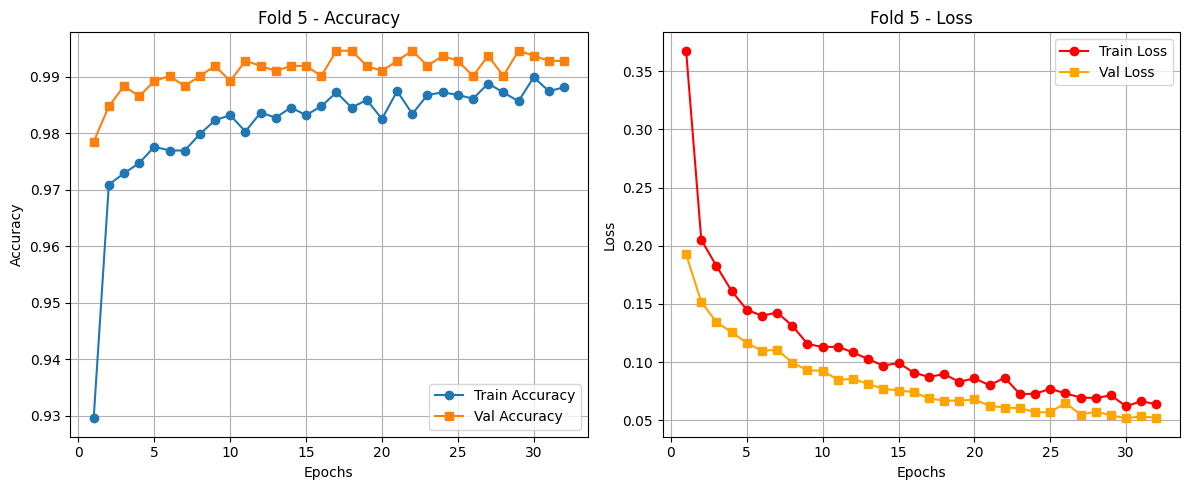

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Config
base_dir = "/content/augmented_data"
img_size = (128, 128)
batch_size = 128
epochs = 32
num_folds = 5

# Step 1: Prepare image paths and labels
data = []
for label_name in os.listdir(base_dir):
    label_dir = os.path.join(base_dir, label_name)
    if os.path.isdir(label_dir):
        for fname in os.listdir(label_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append({
                    'filename': os.path.join(label_dir, fname),
                    'label': 0 if label_name == 'with_mask' else 1
                })

df = pd.DataFrame(data)
print(f"Total samples: {len(df)}")

# Step 2: Define model creation
def create_densenet_model(input_shape=(128, 128, 3)):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Step 3: Plot function for Accuracy and Loss
def plot_accuracy_and_loss(history, fold_no):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='s')
    plt.title(f'Fold {fold_no} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', marker='o', color='red')
    plt.plot(epochs_range, val_loss, label='Val Loss', marker='s', color='orange')
    plt.title(f'Fold {fold_no} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"performance_fold_{fold_no}.png")
    plt.show()

# Step 4: K-Fold Training
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_no = 1
label_map = {0: 'with_mask', 1: 'without_mask'}

for train_idx, val_idx in kf.split(df):
    print(f"\n🔁 Fold {fold_no} / {num_folds}")

    # Split data
    train_df = df.iloc[train_idx].copy().reset_index(drop=True)
    val_df = df.iloc[val_idx].copy().reset_index(drop=True)
    train_df['label'] = train_df['label'].map(label_map)
    val_df['label'] = val_df['label'].map(label_map)

    # Data generators
    datagen = ImageDataGenerator(rescale=1./255)

    train_gen = datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    val_gen = datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Model
    model = create_densenet_model(input_shape=img_size + (3,))

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    # Train
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Save model
    model.save(f"densenet_fold_{fold_no}.h5")
    print(f"✅ Saved model for fold {fold_no}")

    # Plot and save performance
    plot_accuracy_and_loss(history, fold_no)

    fold_no += 1


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 202ms/step - accuracy: 0.9984 - loss: 0.0413
Test Accuracy: 0.9976148009300232


In [ ]:
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model("/content/densenet_fold_5.h5")

# Create converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# OPTIONAL: Enable optimization for size and speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# OPTIONAL: If you want INT8 quantization (smallest & fastest), you also need to set a representative dataset.
# For simplicity, here we keep FP16/FP32. Let me know if you want full INT8 code.

# Convert model
tflite_model = converter.convert()

# Save to file
with open("mobilenet_mask_detector.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved as mobilenet_mask_detector.tflite")


Saved artifact at '/tmp/tmpbe9gl359'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138871642602768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138871642597968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138871642587216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138871642589904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138871642602960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138871642587984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138871642596432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138871642595472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138871642591824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138876927870544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388716425993

In [ ]:
# ================================
# 🚀 1) Load Keras Model
# ================================
import tensorflow as tf

model = tf.keras.models.load_model("/content/densenet_fold_5.h5")

# ================================
# 🚀 2) Create Representative Dataset
# ================================
# Make sure X_train exists and is preprocessed
# If not, you can create dummy data like this:
# X_train = np.random.rand(100,128,128,3).astype("float32")
# But ideally you should use your actual training data.

def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [tf.cast(input_value, tf.float32)]

# ================================
# 🚀 3) Convert to INT8 TFLite
# ================================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_quant_model = converter.convert()

# Save the model
with open("mobilenet_mask_detector_int8.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("✅ INT8 quantized model saved.")

# ================================
# 🚀 4) Load TFLite Model (CPU)
# ================================
import numpy as np
from PIL import Image
import time

interpreter = tf.lite.Interpreter(model_path="mobilenet_mask_detector_int8.tflite")
interpreter.allocate_tensors()
print("✅ Loaded INT8 TFLite model with CPU interpreter.")

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# ================================
# 🚀 5) Single Image Prediction Function
# ================================
def predict_single_image(image_path):
    # Load & preprocess
    img = Image.open(image_path).convert("RGB")
    img = img.resize((128,128))
    img_array = np.array(img)

    # Quantize input to uint8
    input_scale, input_zero_point = input_details[0]['quantization']
    img_array = img_array / 255.0
    img_array = img_array / input_scale + input_zero_point
    img_array = img_array.astype(np.uint8)
    img_array = np.expand_dims(img_array, axis=0)

    # Warm-up
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    # Timing
    start = time.time()
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    end = time.time()

    # Get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_scale, output_zero_point = output_details[0]['quantization']
    prob = (output_data[0][0] - output_zero_point) * output_scale

    label = "Mask" if prob < 0.5 else "No Mask"

    print("\nPrediction:", label)
    print("Probability: {:.4f}".format(prob))
    print("Inference Time: {:.6f} sec\n".format(end - start))
    print("Raw probability value:", prob)
# ================================
# 🚀 6) Example Usage
# ================================
image_path = input("Enter the path to your test image: ")
predict_single_image(image_path)



Saved artifact at '/tmp/tmpj0x28j72'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138871642223440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138876925602576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138876925595664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138876925592976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138876925604880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138876925603344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138876925601808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138876925592208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138876925606608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138876925598736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388769259300

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ INT8 quantized model saved.
✅ Loaded INT8 TFLite model with CPU interpreter.
Enter the path to your test image: /content/download.jpg

Prediction: No Mask
Probability: 0.8555
Inference Time: 0.049114 sec

Raw probability value: 0.85546875
